In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import math

In [2]:
nu = 1e-4
k_cutoff_coarse = 7.5
k_cutoff_fine = 7.5

In [3]:
# ----------------------------
# Fourier Neural Operator Layer
# ----------------------------
class FourierLayer(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(FourierLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy, ioxy -> boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        avail_modes1 = min(self.modes1, x.size(-2))
        avail_modes2 = min(self.modes2, x.size(-1) // 2 + 1)
        out_ft = torch.zeros(
            batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1,
            device=x.device, dtype=torch.cfloat
        )
        out_ft[:, :, :avail_modes1, :avail_modes2] = self.compl_mul2d(
            x_ft[:, :, :avail_modes1, :avail_modes2],
            self.weights[:, :, :avail_modes1, :avail_modes2]
        )
        x = torch.fft.irfft2(out_ft, s=x.shape[-2:])
        return x

# ----------------------------
# Fourier Feature Mapping (for coordinate lifting)
# ----------------------------
class FourierFeatureMapping(nn.Module):
    def __init__(self, input_dim=2, mapping_size=64, scale=10.0):
        """
        Maps 2D coordinates to a (2*mapping_size)-dimensional feature.
        """
        super(FourierFeatureMapping, self).__init__()
        self.mapping_size = mapping_size
        self.register_buffer("B", torch.randn(input_dim, mapping_size) * scale)
    
    def forward(self, coords):
        projection = 2 * math.pi * torch.matmul(coords, self.B)
        fourier_features = torch.cat([torch.cos(projection), torch.sin(projection)], dim=-1)
        return fourier_features.permute(0, 3, 1, 2)

def get_coord_grid(batch_size, height, width, device):
    xs = torch.linspace(0, 1, width, device=device)
    ys = torch.linspace(0, 1, height, device=device)
    grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=-1)
    grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)
    return grid

# ----------------------------
# Modified SuperResUNet for 10-to-10 mapping (NS version)
# ----------------------------
class SuperResUNet(nn.Module):
    def __init__(self, in_channels=10, lift_dim=128, mapping_size=64, mapping_scale=5.0):
        super(SuperResUNet, self).__init__()
        # Fourier feature mapping: maps coordinates to features.
        self.fourier_mapping = FourierFeatureMapping(input_dim=2, mapping_size=mapping_size, scale=mapping_scale)
        # Lifting: concatenate the input with the Fourier features.
        # New channel dimension = in_channels + 2*mapping_size.
        self.lift = nn.Conv2d(in_channels + 2 * mapping_size, lift_dim, kernel_size=1)
        # Encoder: expand channel dimensions.
        self.encoder = nn.Sequential(
            nn.Conv2d(lift_dim, lift_dim * 2, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(lift_dim * 2, lift_dim * 2, 3, padding=1),
            nn.GELU(),
            nn.MaxPool2d(2)
        )
        # Bottleneck with Fourier layer.
        self.bottleneck = nn.Sequential(
            nn.Conv2d(lift_dim * 2, lift_dim * 2, 3, padding=1),
            nn.GELU(),
            FourierLayer(lift_dim * 2, lift_dim * 2, modes1=32, modes2=24),
            nn.BatchNorm2d(lift_dim * 2),
            nn.GELU(),
            nn.Conv2d(lift_dim * 2, lift_dim * 2, 3, padding=1),
            nn.GELU()
        )
        # Decoder: progressively reduce channels back to the target 10 channels.
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(lift_dim * 2, lift_dim, 3, padding=1),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(lift_dim, lift_dim // 2, 3, padding=1),
            nn.GELU(),
            nn.Upsample(size=128, mode='bilinear'),
            nn.Conv2d(lift_dim // 2, 32, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, in_channels, 3, padding=1)
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        device = x.device
        coords = get_coord_grid(B, H, W, device)
        fourier_feats = self.fourier_mapping(coords)
        x_cat = torch.cat([x, fourier_feats], dim=1)
        x_lift = self.lift(x_cat)
        x_enc = self.encoder(x_lift)
        x_bottleneck = self.bottleneck(x_enc)
        x_dec = self.decoder(x_bottleneck)
        return x_dec

In [4]:
# ----------------------------
# Projection Operator: Fine -> Coarse (applied channel–wise)
# ----------------------------
def projection_operator(fine_data, factor=2):
    """
    Downsamples the input spatially by the given factor.
    fine_data: Tensor of shape [B, 10, H, W]
    """
    return fine_data[..., ::factor, ::factor]

def coarse_time_step_NS(coarse_field, dt, dx, dy, nu):
    """
    Advances the coarse 10-channel field one time step using the NS vorticity update.
    The update is applied independently on each channel.
    
    coarse_field: Tensor of shape [B, 10, H, W]
    """
    B, C, H, W = coarse_field.shape
    N = H  # assume square grid
    L = 1.0
    # Create wave number grid (using spacing dx)
    k = torch.fft.fftfreq(N, d=dx) * 2 * math.pi  # shape: (N,)
    KX, KY = torch.meshgrid(k, k, indexing='ij')
    KX = KX.to(coarse_field.device)
    KY = KY.to(coarse_field.device)
    ksq = KX**2 + KY**2
    ksq[0, 0] = 1e-10  # avoid division by zero
    # Expand dimensions for broadcasting: shape [1, 1, N, N]
    ksq_ = ksq.unsqueeze(0).unsqueeze(0)
    x = torch.linspace(0, L, N)
    y = torch.linspace(0, L, N)
    X, Y = torch.meshgrid(x, y)
    forcing = 0.025 * (torch.sin(2 * torch.pi * (X + Y)) + torch.cos(2 * torch.pi * (X + Y)))
    # Compute Fourier transform for each channel
    field_hat = torch.fft.fft2(coarse_field)  # shape [B, 10, H, W]
    # Compute streamfunction for each channel: psi_hat = -field_hat/ksq
    psi_hat = -field_hat / ksq_
    psi = torch.fft.ifft2(psi_hat).real  # streamfunction, shape [B, 10, H, W]
    
    # Compute velocity components via spectral differentiation for each channel:
    KX_ = KX.unsqueeze(0).unsqueeze(0)  # shape [1, 1, H, W]
    KY_ = KY.unsqueeze(0).unsqueeze(0)  # shape [1, 1, H, W]
    u = torch.fft.ifft2(1j * KY_ * psi_hat).real
    v = -torch.fft.ifft2(1j * KX_ * psi_hat).real
    
    # Compute spatial derivatives of the field
    dfield_dx = torch.fft.ifft2(1j * KX_ * field_hat).real
    dfield_dy = torch.fft.ifft2(1j * KY_ * field_hat).real
    
    # Nonlinear advection term (computed channel-wise)
    nonlinear = u * dfield_dx + v * dfield_dy
    
    # Compute Laplacian in Fourier space then invert FFT
    lap_field = torch.fft.ifft2(-ksq_ * field_hat).real
    
    # Explicit Euler update
    field_new = coarse_field + dt * (-nonlinear + nu * lap_field + forcing)
    
    # # De-aliasing using the 2/3 rule
    # cutoff = N // 3
    # mask = ((KX.abs() < cutoff) & (KY.abs() < cutoff)).to(coarse_field.device)
    # mask = mask.unsqueeze(0).unsqueeze(0)  # shape [1, 1, H, W]
    # field_new_hat = torch.fft.fft2(field_new)
    # field_new_hat = field_new_hat * mask
    # field_new = torch.fft.ifft2(field_new_hat).real
    
    return field_new

In [5]:
# ----------------------------
# Data Loader: Load full trajectory (20 time steps) for evaluation
# ----------------------------
def load_single_sample_full(idx=0):
    fine_u = np.load(f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_fine_nu={nu}_mode={k_cutoff_fine}_no_dealias_32to128_with_forcing_new.npy')
    sample_u = fine_u
    sample_u = torch.tensor(sample_u, dtype=torch.float32)
    return sample_u

In [6]:
# ----------------------------
# Evaluation: Iterative Future Extrapolation with AB3 on the Coarse Grid
# ----------------------------

device = 'cpu'#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize models and load saved weights
model_u = SuperResUNet(in_channels=100).to(device)
#model_u.load_state_dict(torch.load("/pscratch/sd/h/hbassi/models/fine_tuning_Ntime_NS_64to128_nu=1e-3_mode=10_best_model_new.pth"))
#model_u.load_state_dict(torch.load('/pscratch/sd/h/hbassi/models/fine_tuning_NS_32to128_nu=1e-3_mode=7-42_complex_best_model.pth'))
#model_u.load_state_dict(torch.load('/pscratch/sd/h/hbassi/models/NS_multi_traj_checkpoint_epoch_2300_spectral_solver_32to128_nu=1e-3_mode=7-42.pth')['model_state_dict'])
model_u.load_state_dict(torch.load(f'/pscratch/sd/h/hbassi/models/NS_multi_traj_checkpoint_epoch_{2100}_spectral_solver_32to128_nu={1e-4}_mode={7.5}_forcing_nor_norm.pth')['model_state_dict'])
#model_u.load_state_dict(torch.load(f'/pscratch/sd/h/hbassi/models/fine_tuning_NS_64to128_nu=1e-3_mode=7-42_complex_best_model.pth'))
model_u.eval()

SuperResUNet(
  (fourier_mapping): FourierFeatureMapping()
  (lift): Conv2d(228, 128, kernel_size=(1, 1), stride=(1, 1))
  (encoder): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): FourierLayer()
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [7]:
idx = 123
sample_u = load_single_sample_full(idx)
sample_u = sample_u.to(device)  

# Coarse grid parameters (assume domain [0,1]x[0,1])
downsample_factor = 4
Lx = 1.0
Nx_fine = 128  # assuming square grid (e.g., 128)
Nx_coarse = Nx_fine // downsample_factor
dx_coarse = Lx / Nx_coarse
dy_coarse = dx_coarse
dt = 0.01      # time step for coarse evolution
nu = 1e-4      # viscosity

print(sample_u.shape)
fine_window_u = sample_u[:100].clone()  # [100, H, W]
print(fine_window_u.shape)

torch.Size([1001, 128, 128])
torch.Size([100, 128, 128])


In [8]:
input_CG = np.load(f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_coarse_nu={nu}_mode={k_cutoff_fine}_no_dealias_32to128_with_forcing_new.npy')[:100]
target_FG = np.load(f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_fine_nu={nu}_mode={k_cutoff_fine}_no_dealias_32to128_with_forcing_new.npy')[:100]
with torch.no_grad():
    pred = model_u(torch.tensor(input_CG).float().unsqueeze(0)).squeeze(0)

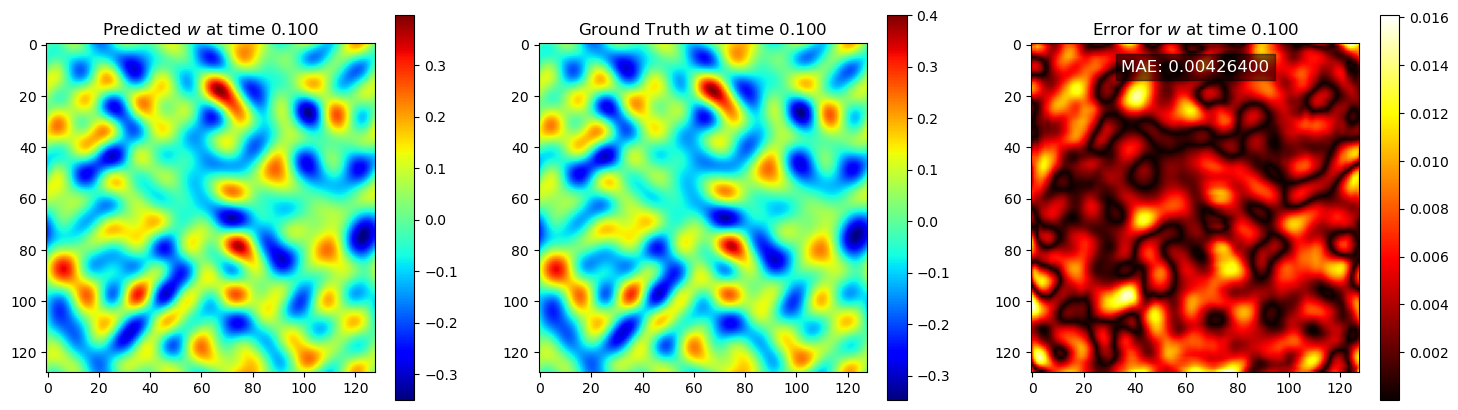

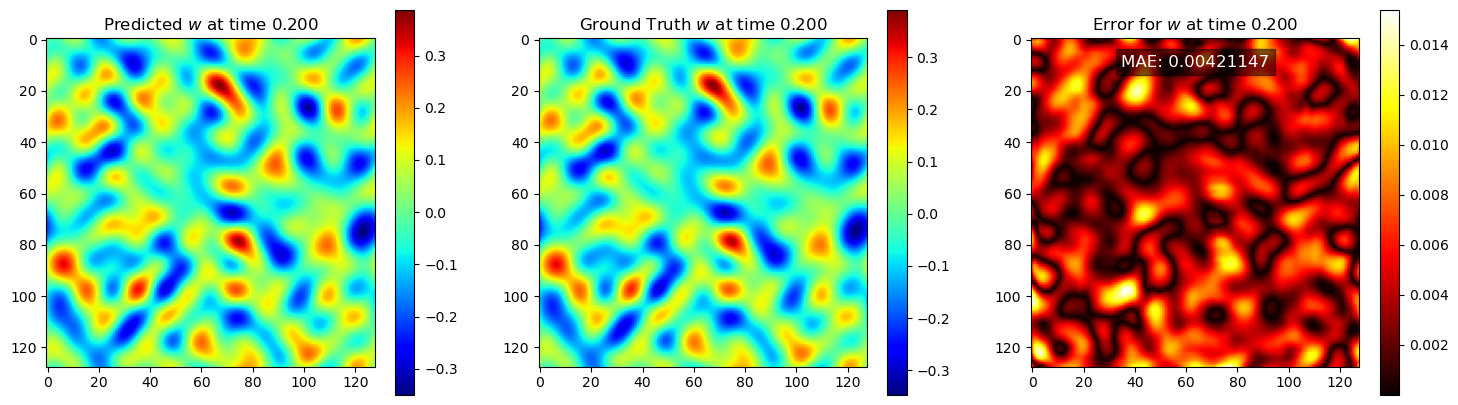

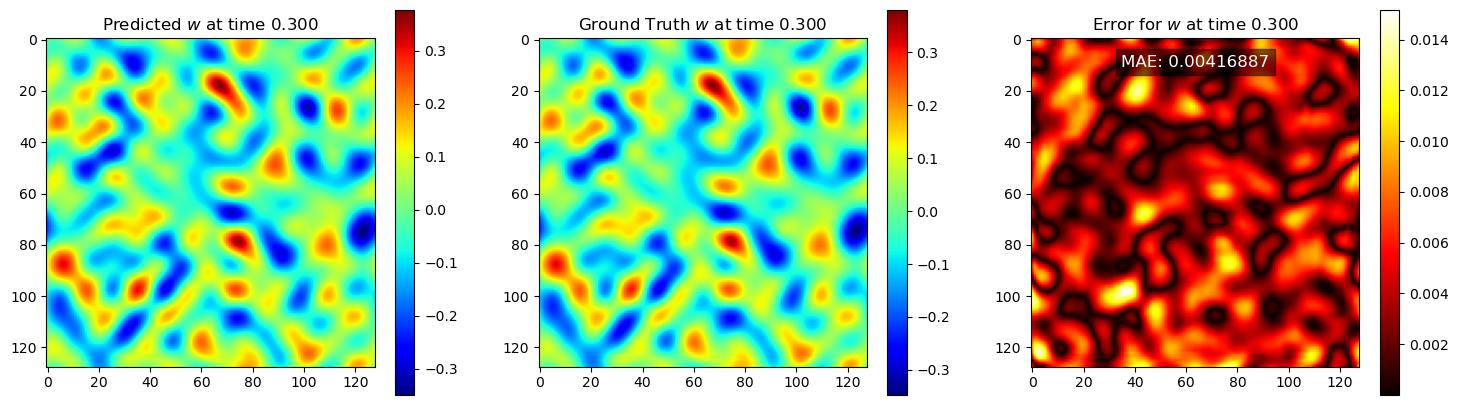

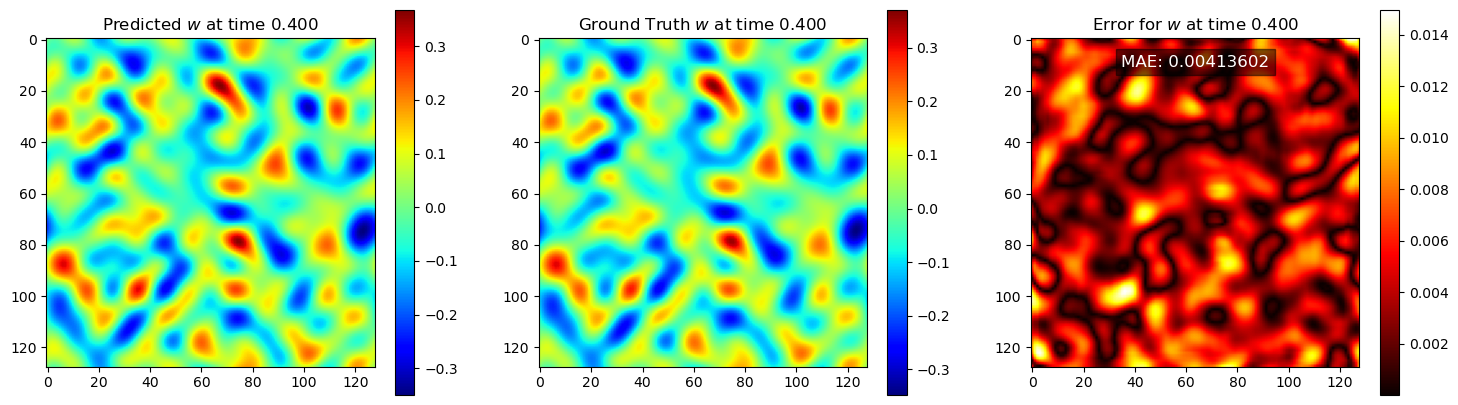

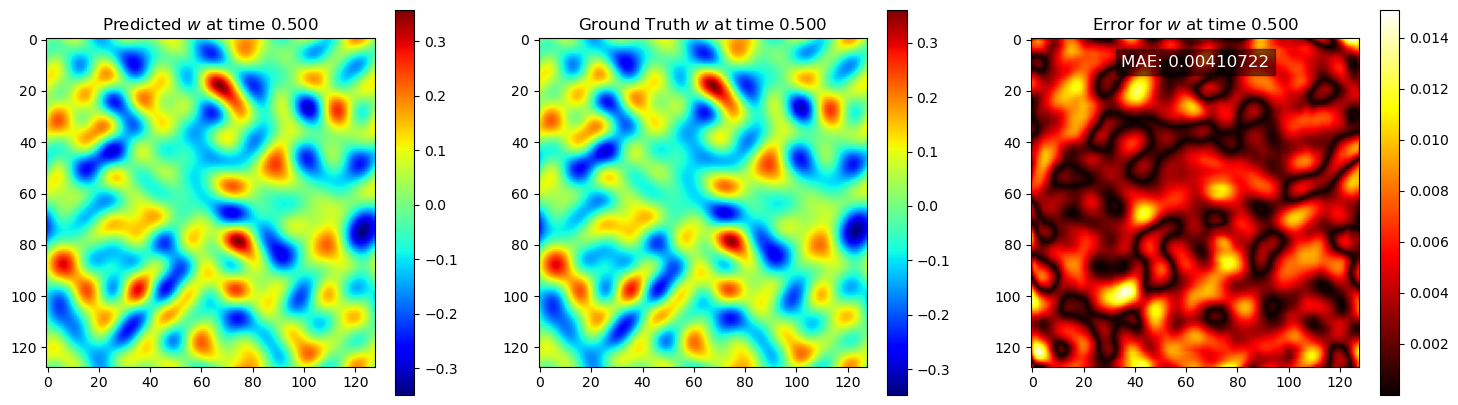

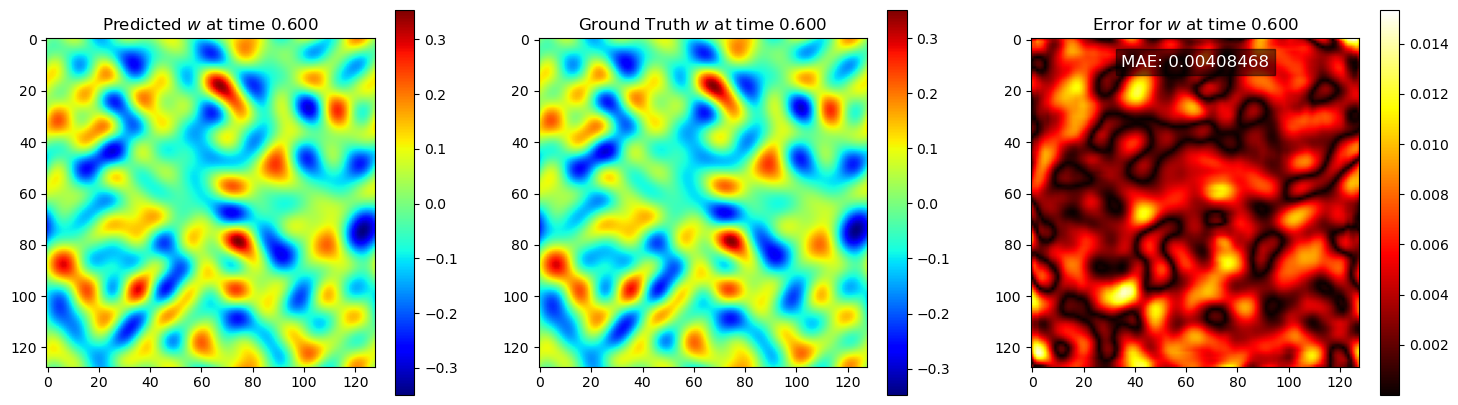

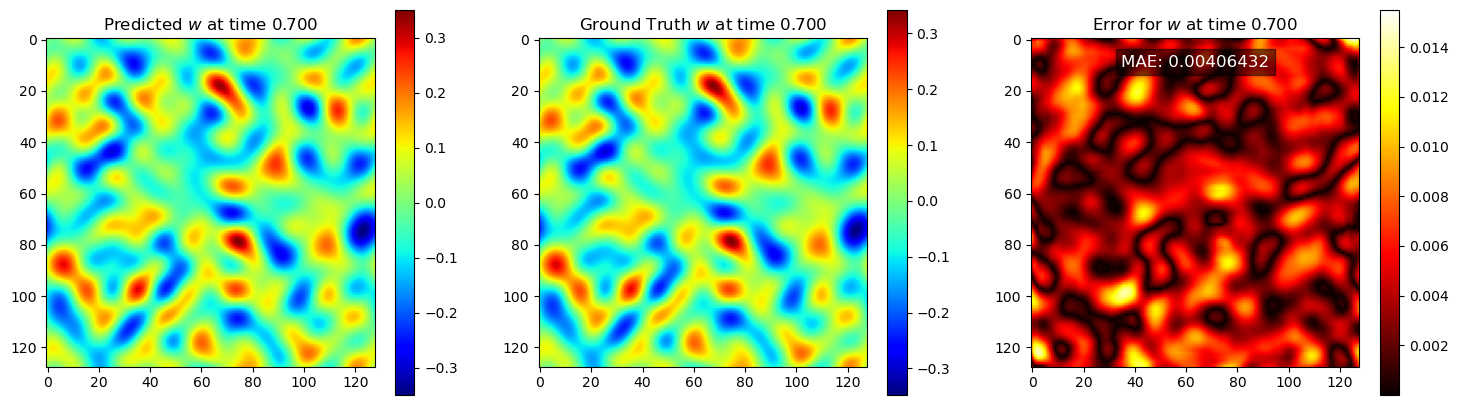

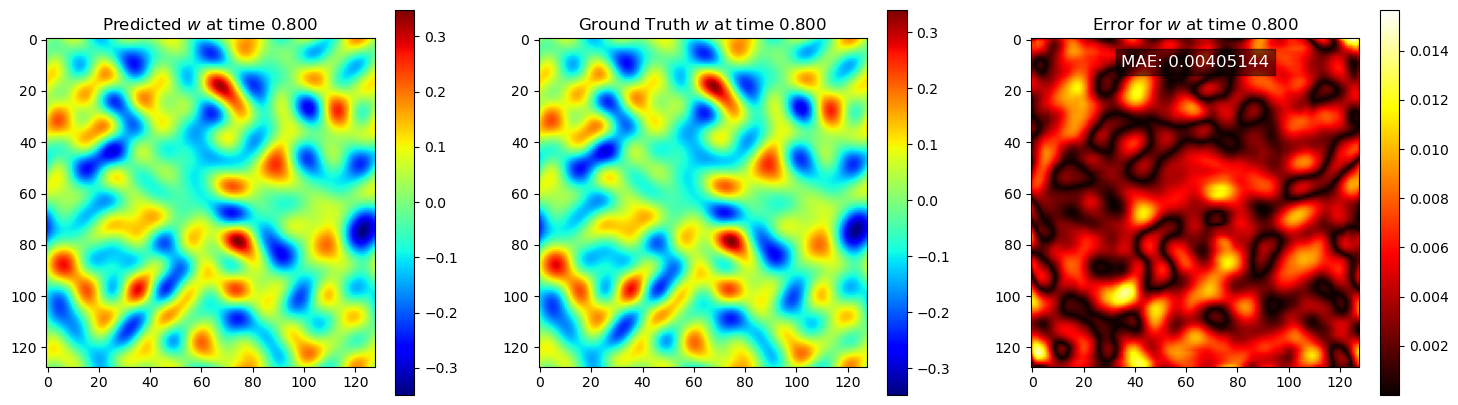

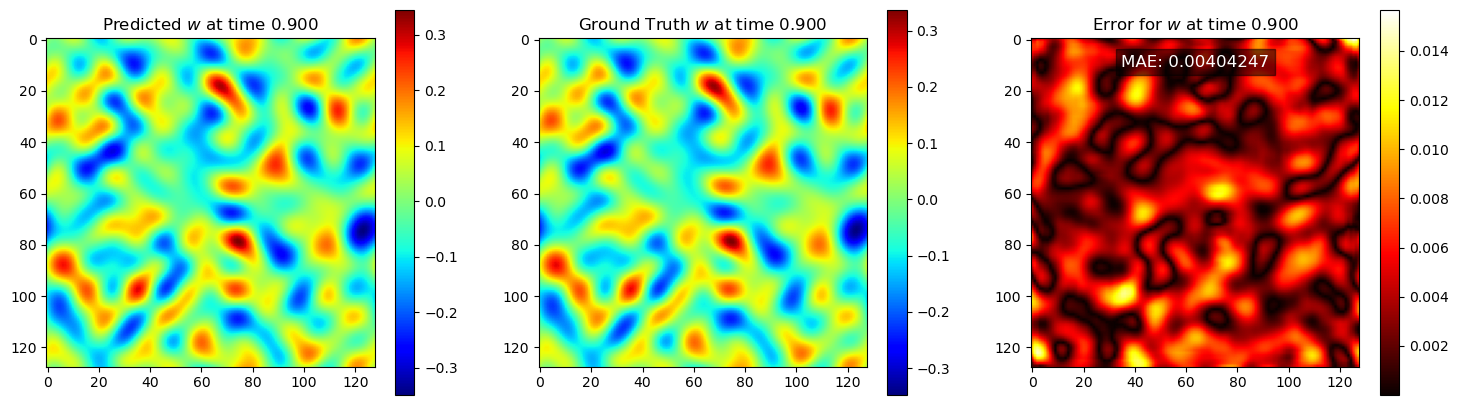

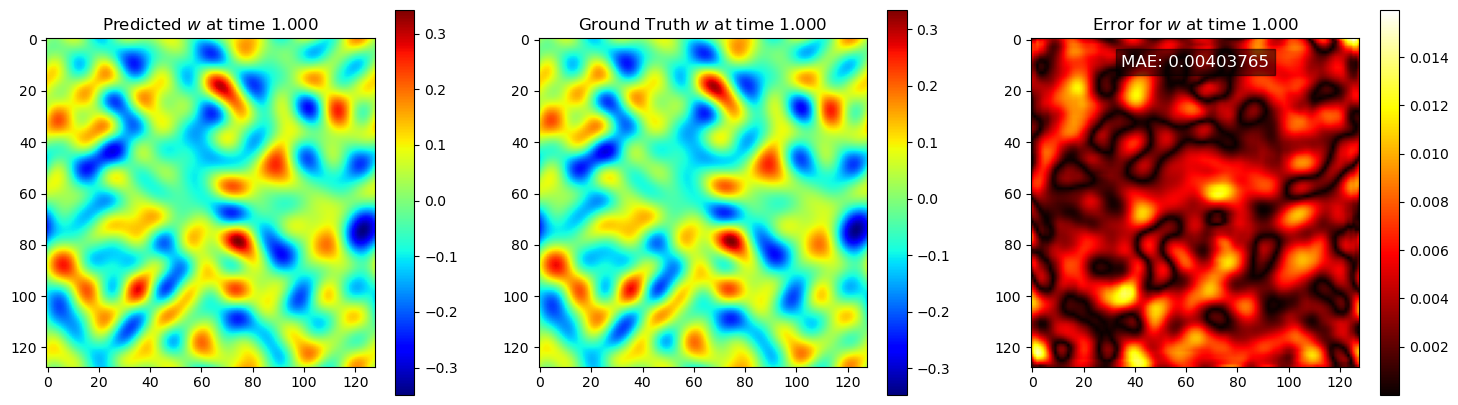

In [9]:
maes = []
for i in range(0, 100, 10):
    plt.figure(figsize=(18, 5))
    time_value = 0.01 * (10 + i)
    time_str = f"{time_value:.3f}" 

        # Left plot: Predicted U
    plt.subplot(1, 3, 1)
    plt.imshow(pred[i].detach().cpu().numpy(), cmap='jet')
    plt.title(fr"Predicted $w$ at time {time_str}")
    plt.colorbar()
    
    # Middle plot: Ground Truth U
    plt.subplot(1, 3, 2)
    plt.imshow(target_FG[i], cmap='jet')
    plt.title(fr"Ground Truth $w$ at time {time_str}")
    plt.colorbar()
    
    # Right plot: Absolute Error (AE)
    plt.subplot(1, 3, 3)
    mae = abs(pred[i].detach().cpu().numpy() - target_FG[i])
    plt.imshow(mae, cmap='hot')
    plt.title(fr"Error for $w$ at time {time_str}")
    plt.colorbar()
    overall_mae = np.mean(mae)  
    maes.append(overall_mae)
    plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
             transform=plt.gca().transAxes,
             fontsize=12, color='white', ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.show()

In [10]:
# import os
# import imageio

# # Create a folder to store the frames
# os.makedirs('frames', exist_ok=True)


# filenames = []

# maes = []
# for i in trange(0, 100):
#     plt.figure(figsize=(18, 5))
#     time_value = 0.01 * ( i)
#     time_str = f"{time_value:.3f}" 

#         # Left plot: Predicted U
#     plt.subplot(1, 3, 1)
#     plt.imshow(pred[i].detach().cpu().numpy(), cmap='jet')
#     plt.title(fr"Predicted $w$ at time {time_str}")
#     plt.colorbar()
    
#     # Middle plot: Ground Truth U
#     plt.subplot(1, 3, 2)
#     plt.imshow(target_FG[i], cmap='jet')
#     plt.title(fr"Ground Truth $w$ at time {time_str}")
#     plt.colorbar()
    
#     # Right plot: Absolute Error (AE)
#     plt.subplot(1, 3, 3)
#     mae = abs(pred[i].detach().cpu().numpy() - target_FG[i])
#     plt.imshow(mae, cmap='hot')
#     plt.title(fr"Error for $w$ at time {time_str}")
#     plt.colorbar()
#     overall_mae = np.mean(mae)  
#     maes.append(overall_mae)
#     plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
#              transform=plt.gca().transAxes,
#              fontsize=12, color='white', ha='center', va='top',
#              bbox=dict(facecolor='black', alpha=0.5))
#     filename = f"frames/frame_{i:03d}.png"
#     plt.savefig(filename)
#     filenames.append(filename)
#     plt.close()
    

# # Create a GIF from the saved images
# gif_filename = 'reconstruction_animation.gif'
# with imageio.get_writer(gif_filename, mode='I', duration=0.001) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# print(f"GIF saved as {gif_filename}")

# # Optionally, remove the temporary frame files if they're no longer needed
# for filename in filenames:
#     os.remove(filename)


In [11]:
model_u.load_state_dict(torch.load(f"/pscratch/sd/h/hbassi/models/fine_tuning_NS_32to128_nu={1e-4}_mode={7.5}_with_forcing_no_norm_best_model.pth"))
model_u.eval()

SuperResUNet(
  (fourier_mapping): FourierFeatureMapping()
  (lift): Conv2d(228, 128, kernel_size=(1, 1), stride=(1, 1))
  (encoder): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): FourierLayer()
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): GELU(approximate='none')
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode='bilinear')
    (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [12]:
# Compute initial coarse window by projecting the fine window
coarse_window_u = projection_operator(fine_window_u.unsqueeze(0), factor=downsample_factor).squeeze(0)  # [10, Hc, Wc]

In [13]:
coarse_window_u.shape, coarse_window_u.unsqueeze(0).shape

(torch.Size([100, 32, 32]), torch.Size([1, 100, 32, 32]))

In [14]:
num_extrap_steps = 900
pred_sequence_u = []
coarse_field_tp = coarse_time_step_NS(coarse_window_u.unsqueeze(0), dt, dx_coarse, dy_coarse, nu)
coarse_window = coarse_window_u

/global/homes/h/hbassi/.local/perlmutter/python-3.11/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
for step in trange(num_extrap_steps):
    # Use the NS time-stepping function (explicit Euler update channel–wise)
    # Note: coarse_time_step_NS expects an input of shape [B, 10, Hc, Wc]
    updated_coarse = coarse_time_step_NS(coarse_window.unsqueeze(0), dt, dx_coarse, dy_coarse, nu).squeeze(0)
    
    # Extract the new coarse state. Here, we take the last channel as the updated state.
    new_coarse_state = updated_coarse[-1]
    
    # Update the sliding window: drop the oldest state and append the new state
    coarse_window = torch.cat([coarse_window[1:], new_coarse_state.unsqueeze(0)], dim=0)
    
    # Prepare the coarse input for the network (shape: [1, 10, Hc, Wc])
    coarse_input = coarse_window.unsqueeze(0)
    
    # Superresolve the coarse field to obtain the fine state predictions
    pred_fine = model_u(coarse_input)  # output shape: [1, 10, H, W]
    next_fine = pred_fine[:, -1, :, :]  # extract the immediate next fine state
    
    # Save the predicted fine state and update the fine window
    pred_sequence_u.append(next_fine.squeeze(0))
    fine_window_u = torch.cat([fine_window_u[1:], next_fine], dim=0)

    

# Stack predictions: [num_extrap_steps, H, W]
pred_sequence_u = torch.stack(pred_sequence_u, dim=0)
gt_u = sample_u[100:]

100%|██████████| 900/900 [00:37<00:00, 24.11it/s]


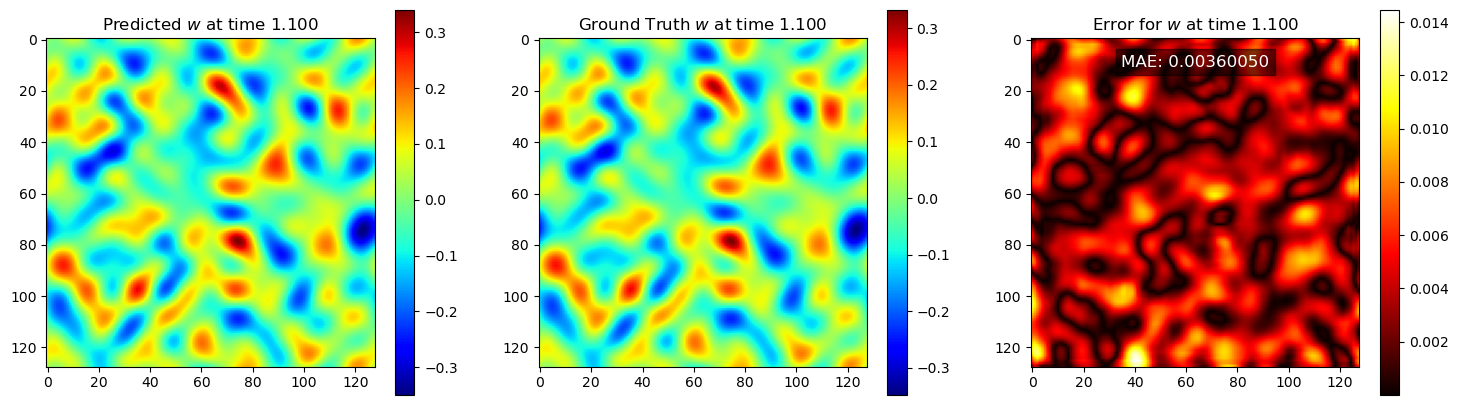

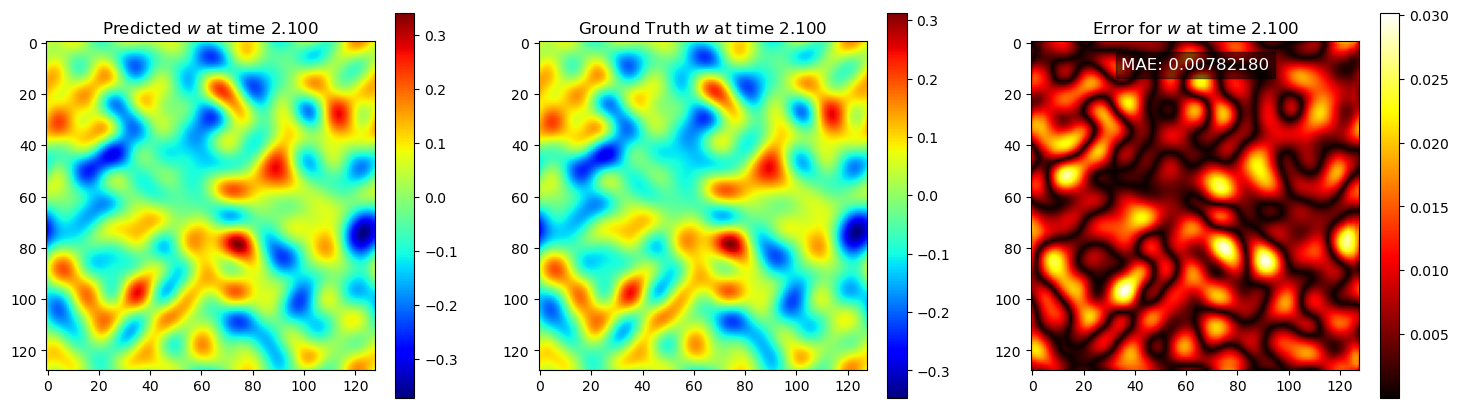

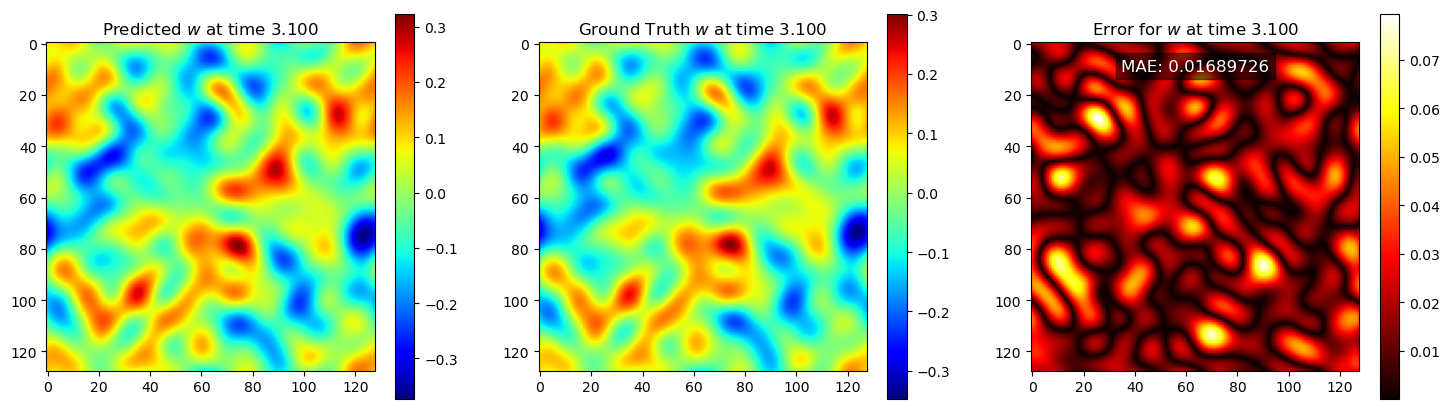

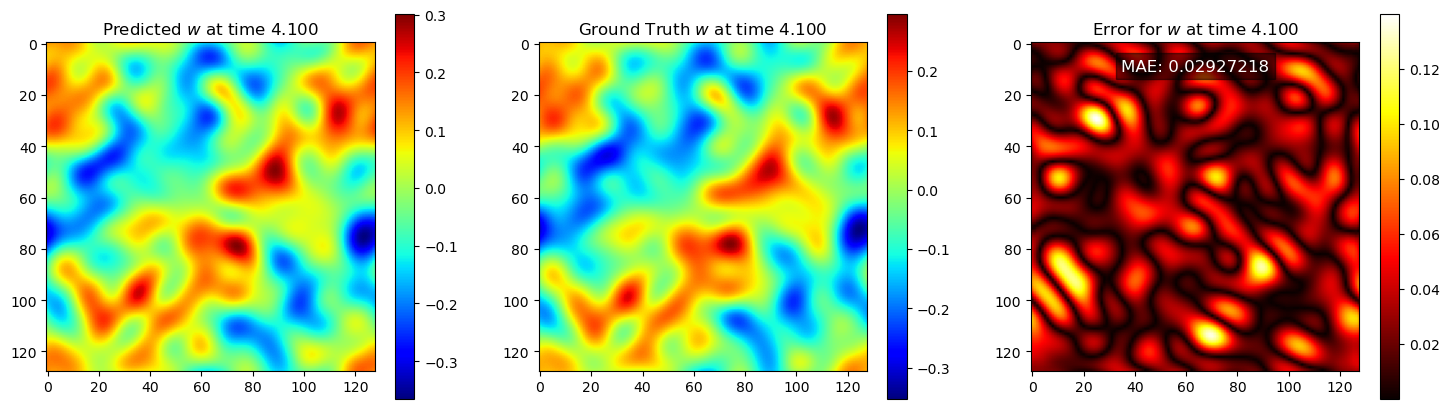

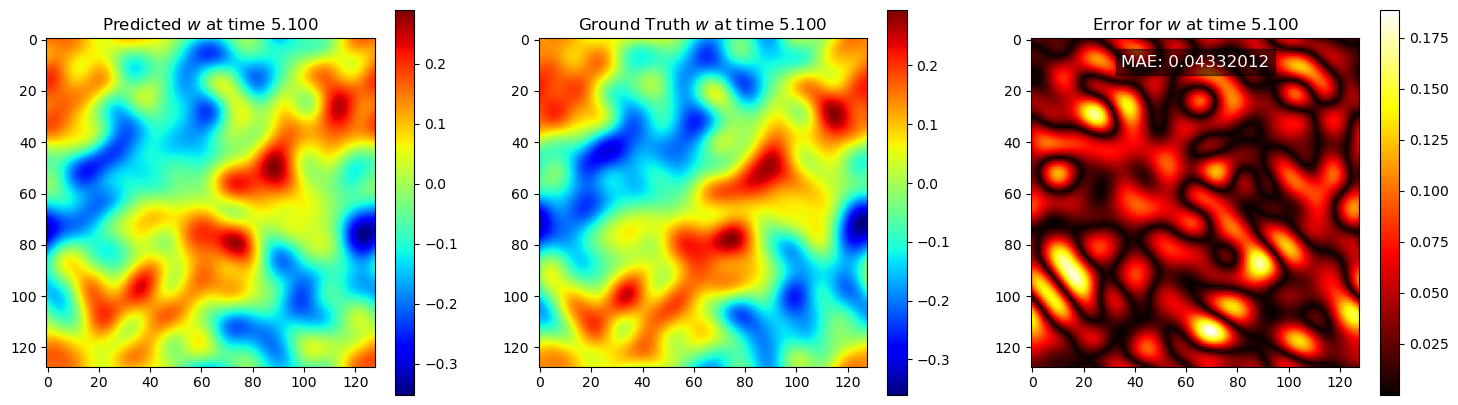

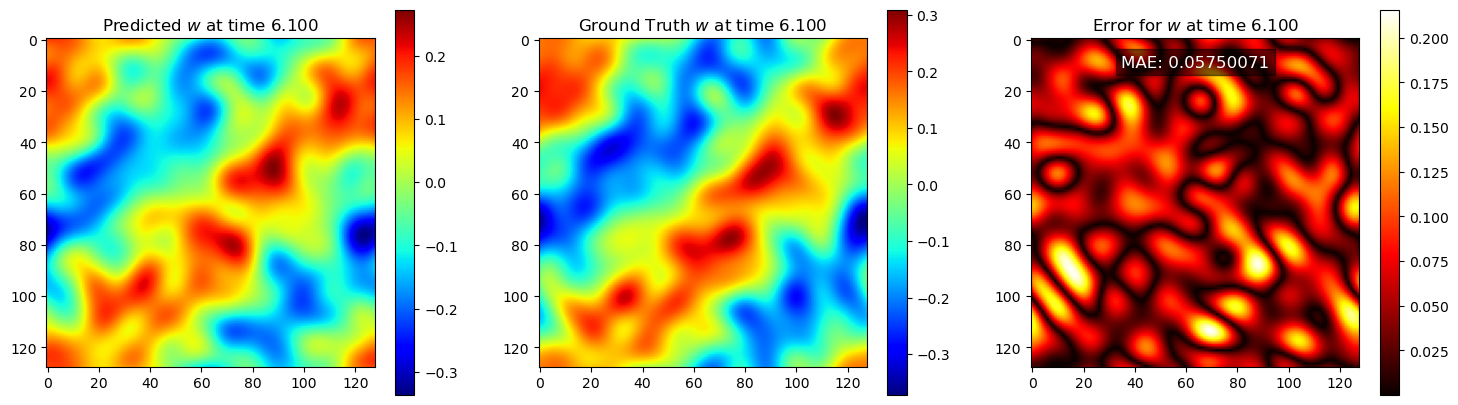

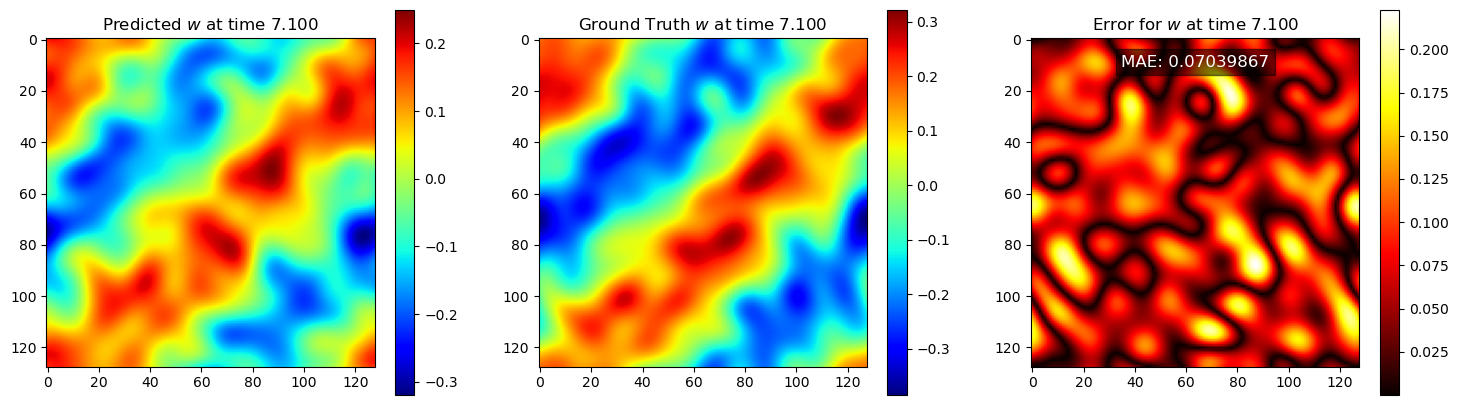

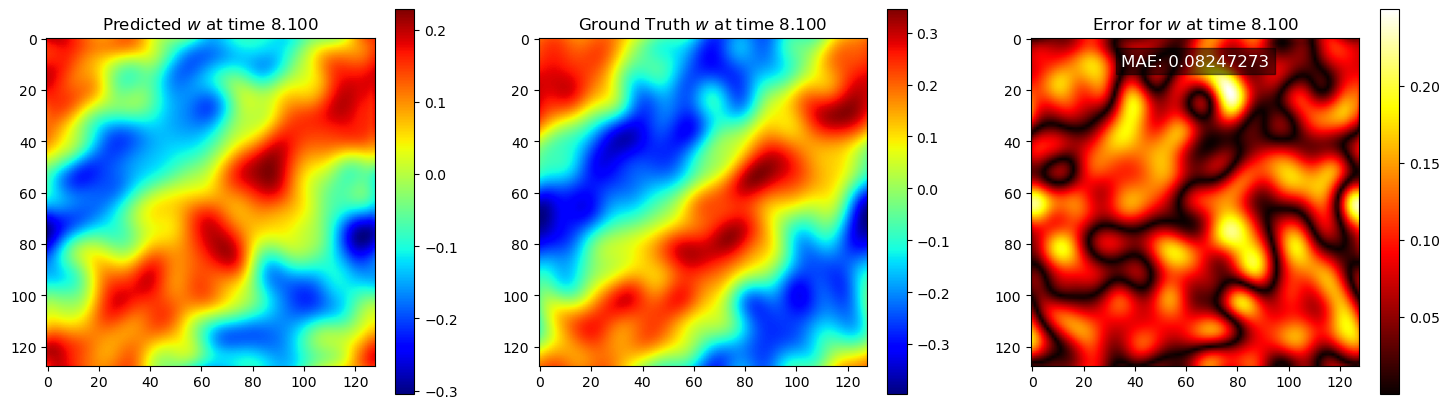

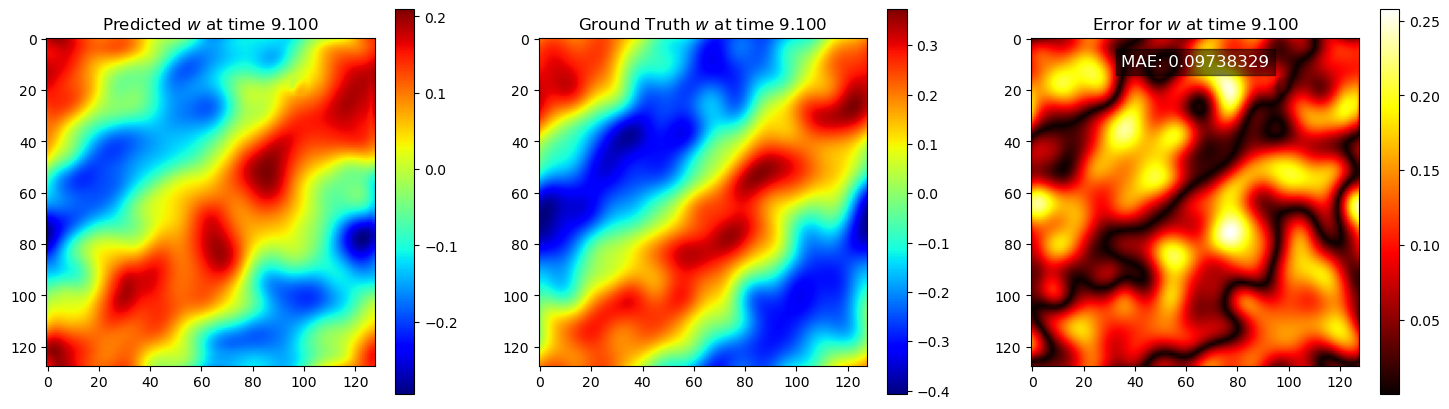

In [16]:
maes = []
for i in range(0, num_extrap_steps, 100):
    plt.figure(figsize=(18, 5))
    time_value = 1 + 0.01 * (10 + i)
    time_str = f"{time_value:.3f}" 

        # Left plot: Predicted U
    plt.subplot(1, 3, 1)
    plt.imshow(pred_sequence_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(fr"Predicted $w$ at time {time_str}")
    plt.colorbar()
    
    # Middle plot: Ground Truth U
    plt.subplot(1, 3, 2)
    plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(fr"Ground Truth $w$ at time {time_str}")
    plt.colorbar()
    
    # Right plot: Absolute Error (AE)
    plt.subplot(1, 3, 3)
    mae = abs(pred_sequence_u[i] - gt_u[i]).detach().cpu().numpy()
    plt.imshow(mae, cmap='hot')
    plt.title(fr"Error for $w$ at time {time_str}")
    plt.colorbar()
    overall_mae = np.mean(mae)  
    maes.append(overall_mae)
    plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
             transform=plt.gca().transAxes,
             fontsize=12, color='white', ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.show()

In [17]:
cg_dyns = np.load(f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_coarse_nu={nu}_mode={k_cutoff_fine}_no_dealias_32to128_with_forcing_new.npy')[100:]

In [18]:
cg_dyns.shape

(901, 32, 32)

In [19]:
# from PIL import Image
# maes_pred = []
# maes_inter = []
# for i in range(0, num_extrap_steps, 100):
#     # Compute time for plot titles
#     time_value = 1 + 0.01 * (10 + i)
#     time_str = f"{time_value:.3f}" 

#     # Convert ground truth U to numpy array and get target dimensions (width, height)
#     gt_u_np = gt_u[i].detach().cpu().numpy()
#     target_dims = (gt_u_np.shape[1], gt_u_np.shape[0])
    
#     # Ensure cg_dyns[i] is a NumPy array (convert if it is a tensor)
#     cg_dyn_np = cg_dyns[i]
#     if not isinstance(cg_dyn_np, np.ndarray):
#         cg_dyn_np = cg_dyn_np.detach().cpu().numpy()
    
#     # Convert the coarse data to a PIL image (using mode 'F' for floating point data)
#     im = Image.fromarray(cg_dyn_np.astype(np.float32), mode='F')
    
#     # Resize using bicubic interpolation
#     im_resized = im.resize(target_dims, resample=Image.BICUBIC)
#     upsampled_cg_dyn = np.array(im_resized)
    
#     # Convert predicted U to numpy array
#     pred_np = pred_sequence_u[i].detach().cpu().numpy()
    
#     # Compute common color limits for group 1 (Predicted U and Ground Truth U)
#     vmin_group1 = min(pred_np.min(), gt_u_np.min())
#     vmax_group1 = max(pred_np.max(), gt_u_np.max())
    
#     # Compute common color limits for group 2 (Coarse U and Upsampled Coarse U)
#     vmin_group2 = min(cg_dyn_np.min(), upsampled_cg_dyn.min())
#     vmax_group2 = max(cg_dyn_np.max(), upsampled_cg_dyn.max())
#     maes_pred.append(np.mean(np.abs(pred_np - gt_u_np)))
#     maes_inter.append(np.mean(np.abs(upsampled_cg_dyn - gt_u_np)))
#     # Create a 1x4 grid of subplots
#     fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    
#     # Left plot: Predicted U (Group 1)
#     im0 = axs[0].imshow(pred_np, cmap='jet', vmin=vmin_group1, vmax=vmax_group1)
#     axs[0].set_title(fr"Predicted $w$ at time {time_str}")
    
#     # Second plot: Ground Truth U (Group 1)
#     im1 = axs[1].imshow(gt_u_np, cmap='jet', vmin=vmin_group1, vmax=vmax_group1)
#     axs[1].set_title(fr"Ground Truth $w$ at time {time_str}")
    
#     # Third plot: Original Coarse U (Group 2)
#     im2 = axs[2].imshow(cg_dyn_np, cmap='jet', vmin=vmin_group2, vmax=vmax_group2)
#     axs[2].set_title(fr"Coarse $w$ at time {time_str}")
    
#     # Fourth plot: Upsampled Coarse U (Group 2)
#     im3 = axs[3].imshow(upsampled_cg_dyn, cmap='jet', vmin=vmin_group2, vmax=vmax_group2)
#     axs[3].set_title(fr"Upsampled Coarse $w$ at time {time_str}")
    
#     # Add a colorbar for group 1 (first 2 subplots)
#     cbar1 = fig.colorbar(im0, ax=axs[0:2], orientation='vertical', fraction=0.02, pad=0.04)
#    # cbar1.set_label("Group 1 Color Scale")
    
#     # Add a colorbar for group 2 (last 2 subplots)
#     cbar2 = fig.colorbar(im2, ax=axs[2:4], orientation='vertical', fraction=0.02, pad=0.04)
#     #cbar2.set_label("Group 2 Color Scale")
    
#     plt.show()


In [20]:
# fno_maes = np.load(f'fno_maes_NavierStokes_test_traj_fine_nu={nu}_mode={k_cutoff_fine}_no_dealias_32to128_with_forcing_new.npy')
# plt.semilogy(np.array(list(range(0, num_extrap_steps))) * ( 0.01 ) + 1, maes_pred, label='FUnet')
# plt.semilogy(np.array(list(range(0, num_extrap_steps))) * ( 0.01 ) + 1, maes_inter, label='interpolation')
# plt.semilogy(np.array(list(range(0, num_extrap_steps))) * ( 0.01 ) + 1, fno_maes, label='FNO')
# plt.xlabel('t')
# plt.ylabel('MAE')
# plt.title('Future time extrapolation model comparison')
# plt.legend()
# plt.tight_layout()
# plt.savefig('./figures/fine_tuning_test_extrapolation_NS_32to128_nu=1e-4_mode=3.75_with_forcing_no_norm_best_model.png')

In [21]:
# maes = []
# for i in range(0, 200, 10):
#     # Compute time for plot titles
#     time_value = 1 + 0.01 * (10 + i)
#     time_str = f"{time_value:.3f}" 

#     # Convert ground truth U to numpy array and get target dimensions (width, height)
#     gt_u_np = gt_u[i].detach().cpu().numpy()
#     target_dims = (gt_u_np.shape[1], gt_u_np.shape[0])
    
#     # Ensure cg_dyns[i] is a NumPy array (convert if it is a tensor)
#     cg_dyn_np = cg_dyns[i]
#     if not isinstance(cg_dyn_np, np.ndarray):
#         cg_dyn_np = cg_dyn_np.detach().cpu().numpy()
    
#     # Convert the coarse data to a PIL image (using mode 'F' for floating point data)
#     im = Image.fromarray(cg_dyn_np.astype(np.float32), mode='F')
    
#     # Resize using bicubic interpolation
#     im_resized = im.resize(target_dims, resample=Image.BICUBIC)
#     upsampled_cg_dyn = np.array(im_resized)
    
#     # Convert predicted U to numpy array
#     pred_np = pred_sequence_u[i].detach().cpu().numpy()
    
#     # Compute common color limits for group 1 (Predicted U and Ground Truth U)
#     vmin_group1 = min(pred_np.min(), gt_u_np.min())
#     vmax_group1 = max(pred_np.max(), gt_u_np.max())
    
#     # Compute common color limits for group 2 (Coarse U and Upsampled Coarse U)
#     vmin_group2 = min(cg_dyn_np.min(), upsampled_cg_dyn.min())
#     vmax_group2 = max(cg_dyn_np.max(), upsampled_cg_dyn.max())
    
#     # Create a 1x4 grid of subplots
#     fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    
#     # Left plot: Predicted U (Group 1)
#     im0 = axs[0].imshow(pred_np, cmap='jet', vmin=vmin_group1, vmax=vmax_group1)
#     axs[0].set_title(f"Predicted U at time {time_str}")
    
#     # Second plot: Ground Truth U (Group 1)
#     im1 = axs[1].imshow(gt_u_np, cmap='jet', vmin=vmin_group1, vmax=vmax_group1)
#     axs[1].set_title(f"Ground Truth U at time {time_str}")
    
#     # Third plot: Original Coarse U (Group 2)
#     im2 = axs[2].imshow(cg_dyn_np, cmap='jet', vmin=vmin_group2, vmax=vmax_group2)
#     axs[2].set_title(f"Coarse U at time {time_str}")
    
#     # Fourth plot: Upsampled Coarse U (Group 2)
#     im3 = axs[3].imshow(upsampled_cg_dyn, cmap='jet', vmin=vmin_group2, vmax=vmax_group2)
#     axs[3].set_title(f"Upsampled Coarse U at time {time_str}")
    
#     # Add a colorbar for group 1 (first 2 subplots)
#     cbar1 = fig.colorbar(im0, ax=axs[0:2], orientation='vertical', fraction=0.02, pad=0.04)
#    # cbar1.set_label("Group 1 Color Scale")
    
#     # Add a colorbar for group 2 (last 2 subplots)
#     cbar2 = fig.colorbar(im2, ax=axs[2:4], orientation='vertical', fraction=0.02, pad=0.04)
#     #cbar2.set_label("Group 2 Color Scale")
    
#     plt.show()


In [22]:
# Create a folder to store the frames
from PIL import Image
os.makedirs('frames', exist_ok=True)
filenames = []

maes_pred = []
maes_inter = []
for i in trange(0, num_extrap_steps):
    # Compute time for plot titles
    time_value = 1 + 0.01 * (10 + i)
    time_str = f"{time_value:.3f}" 

    # Convert ground truth U to numpy array and get target dimensions (width, height)
    gt_u_np = gt_u[i].detach().cpu().numpy()
    target_dims = (gt_u_np.shape[1], gt_u_np.shape[0])
    
    # Ensure cg_dyns[i] is a NumPy array (convert if it is a tensor)
    cg_dyn_np = cg_dyns[i]
    if not isinstance(cg_dyn_np, np.ndarray):
        cg_dyn_np = cg_dyn_np.detach().cpu().numpy()
    
    # Convert the coarse data to a PIL image (using mode 'F' for floating point data)
    im = Image.fromarray(cg_dyn_np.astype(np.float32), mode='F')
    
    # Resize using bicubic interpolation
    im_resized = im.resize(target_dims, resample=Image.BICUBIC)
    upsampled_cg_dyn = np.array(im_resized)
    
    # Convert predicted U to numpy array
    pred_np = pred_sequence_u[i].detach().cpu().numpy()
    
    # Compute common color limits for group 1 (Predicted U and Ground Truth U)
    vmin_group1 = min(pred_np.min(), gt_u_np.min())
    vmax_group1 = max(pred_np.max(), gt_u_np.max())
    
    # Compute common color limits for group 2 (Coarse U and Upsampled Coarse U)
    vmin_group2 = min(cg_dyn_np.min(), upsampled_cg_dyn.min())
    vmax_group2 = max(cg_dyn_np.max(), upsampled_cg_dyn.max())
    
    # Create a 1x4 grid of subplots
    fig, axs = plt.subplots(1, 4, figsize=(24, 5))
    
    # Left plot: Predicted U (Group 1)
    im0 = axs[0].imshow(pred_np, cmap='jet', vmin=vmin_group1, vmax=vmax_group1)
    axs[0].set_title(fr"Predicted $w$ at time {time_str}")
    
    # Second plot: Ground Truth U (Group 1)
    im1 = axs[1].imshow(gt_u_np, cmap='jet', vmin=vmin_group1, vmax=vmax_group1)
    axs[1].set_title(fr"Ground Truth $w$ at time {time_str}")
    
    # Third plot: Original Coarse U (Group 2)
    im2 = axs[2].imshow(cg_dyn_np, cmap='jet', vmin=vmin_group2, vmax=vmax_group2)
    axs[2].set_title(fr"Coarse $w$ at time {time_str}")
    
    # Fourth plot: Upsampled Coarse U (Group 2)
    im3 = axs[3].imshow(upsampled_cg_dyn, cmap='jet', vmin=vmin_group2, vmax=vmax_group2)
    axs[3].set_title(fr"Upsampled Coarse $w$ at time {time_str}")
    maes_pred.append(np.mean(np.abs(pred_np - gt_u_np)))
    maes_inter.append(np.mean(np.abs(upsampled_cg_dyn - gt_u_np)))
    # Add a colorbar for group 1 (first 2 subplots)
    cbar1 = fig.colorbar(im0, ax=axs[0:2], orientation='vertical', fraction=0.02, pad=0.04)
   # cbar1.set_label("Group 1 Color Scale")
    
    # Add a colorbar for group 2 (last 2 subplots)
    cbar2 = fig.colorbar(im2, ax=axs[2:4], orientation='vertical', fraction=0.02, pad=0.04)
    #cbar2.set_label("Group 2 Color Scale")
    filename = f"frames/frame_{i:03d}.png"
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    

# Create a GIF from the saved images
gif_filename = 'extrapolation_animation.gif'
with imageio.get_writer(gif_filename, mode='I', duration=1e-7) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as {gif_filename}")

# Optionally, remove the temporary frame files if they're no longer needed
for filename in filenames:
    os.remove(filename)


100%|██████████| 900/900 [08:43<00:00,  1.72it/s]
/tmp/ipykernel_1644799/3013550111.py:77: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as extrapolation_animation.gif


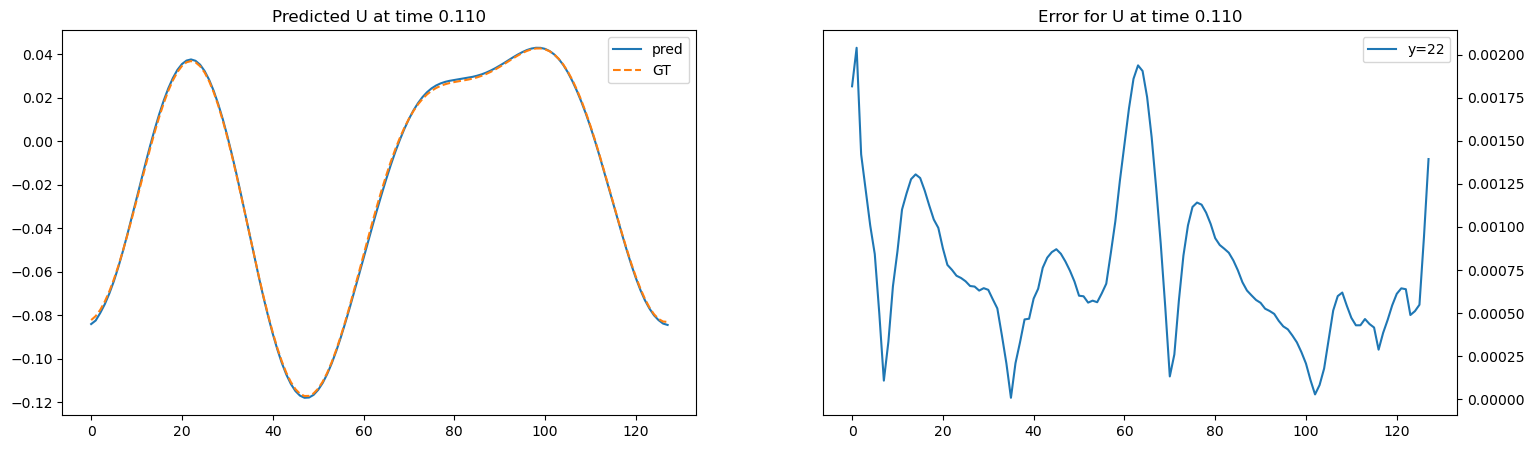

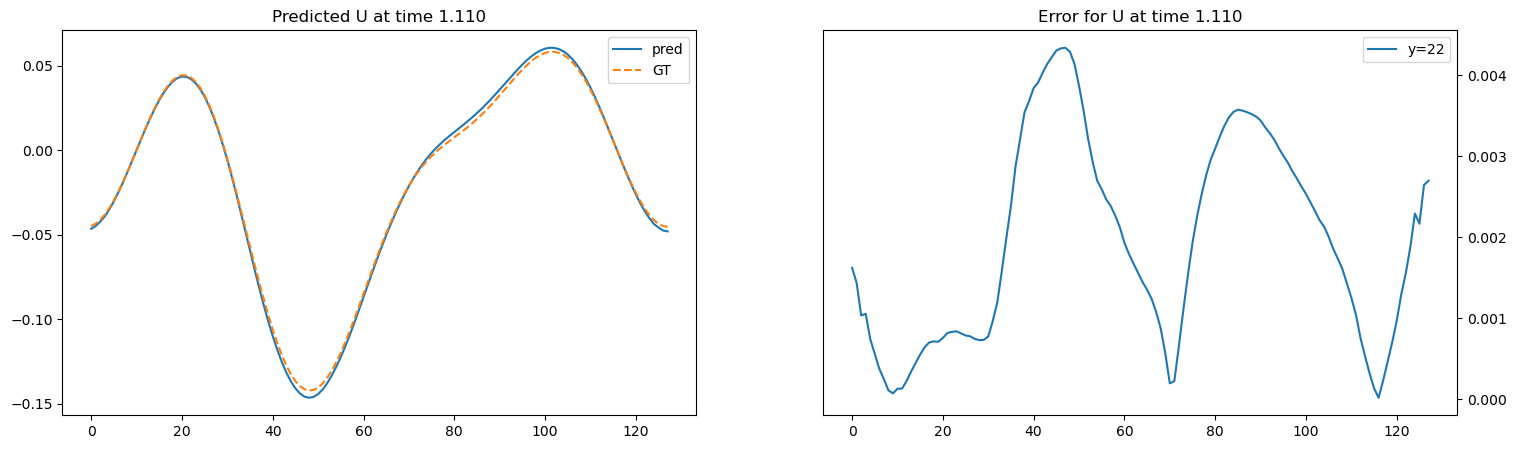

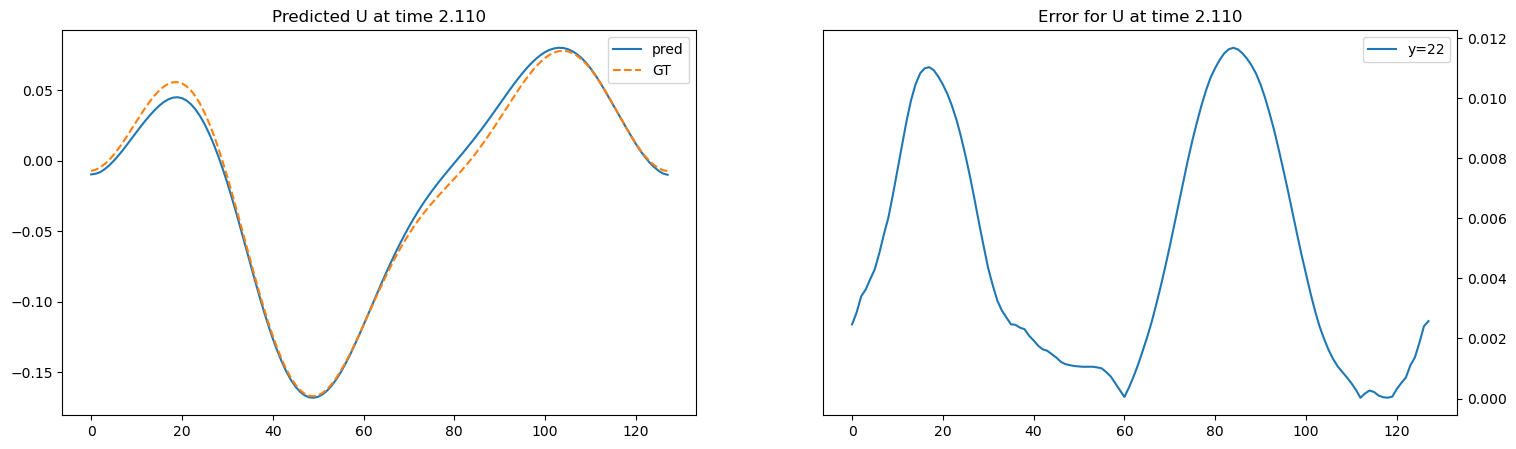

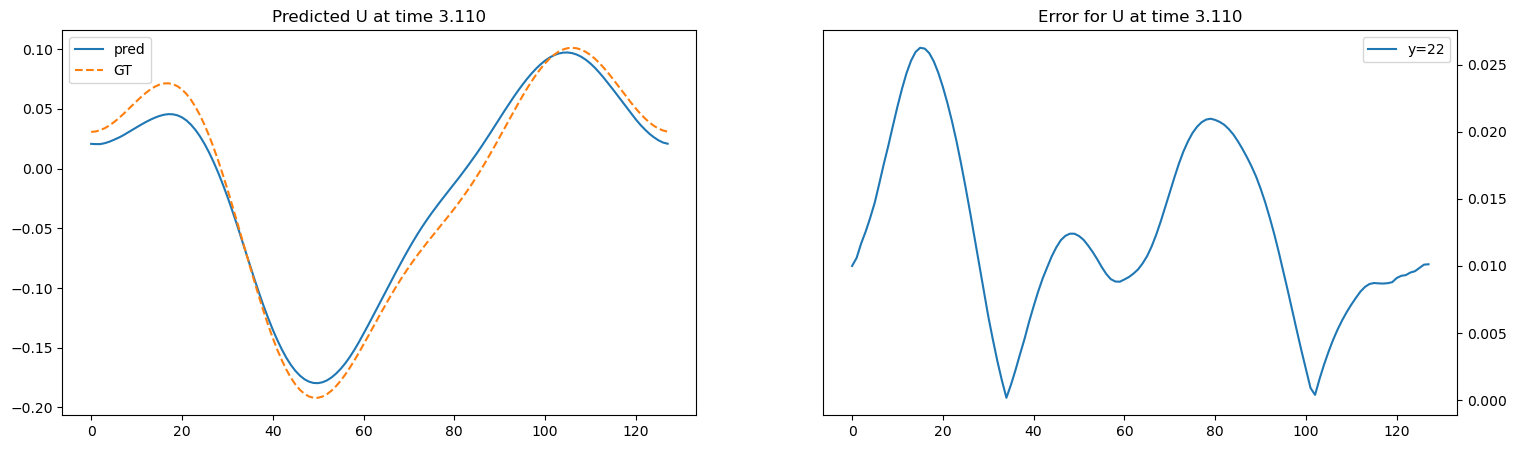

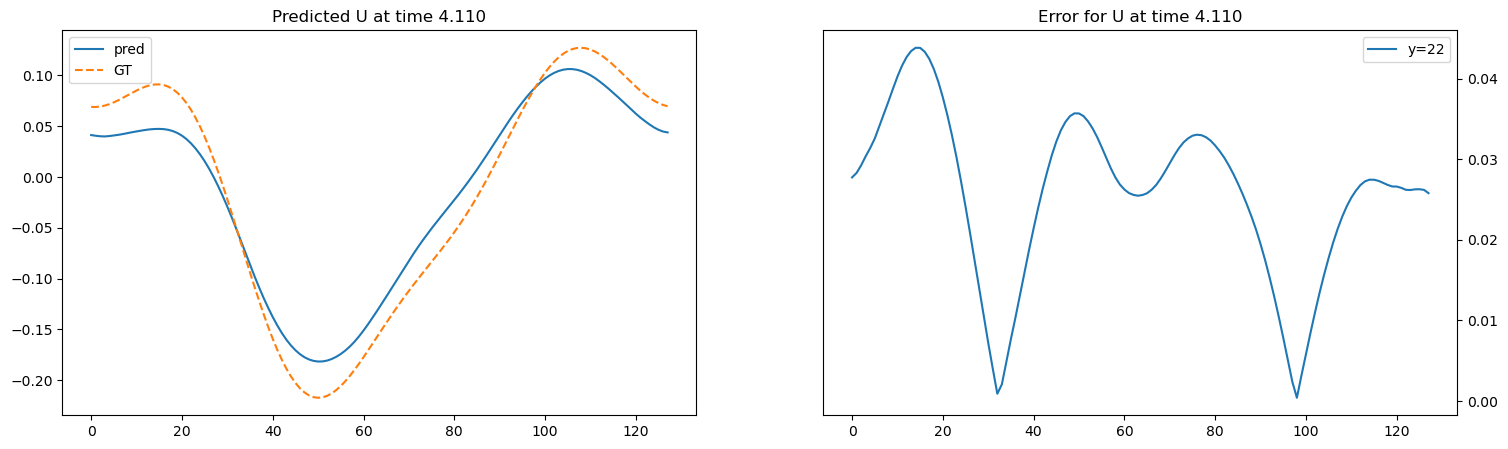

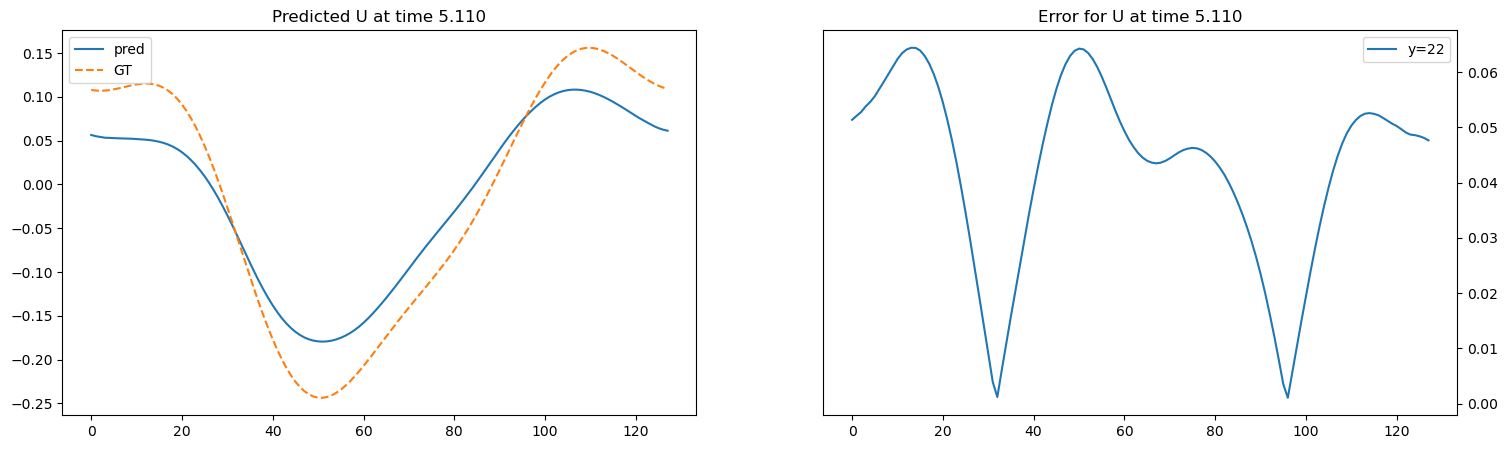

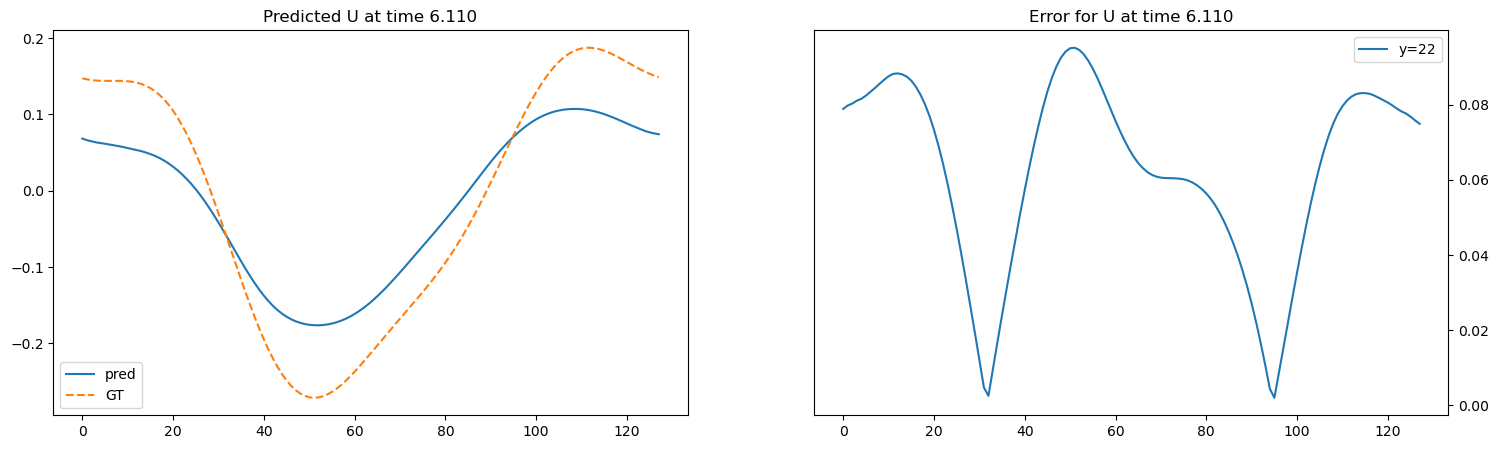

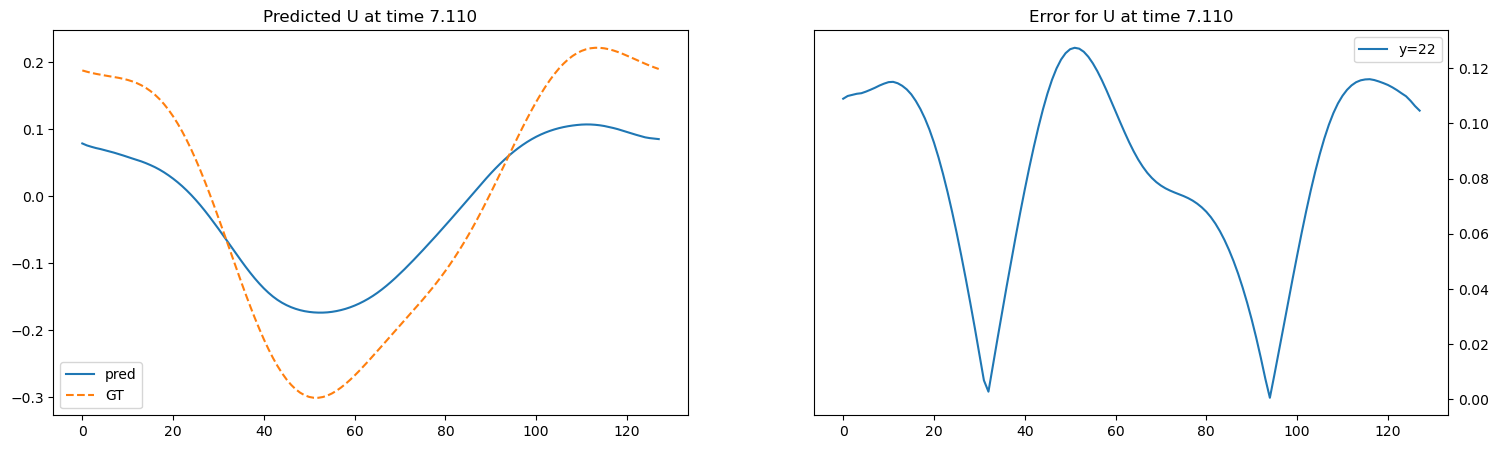

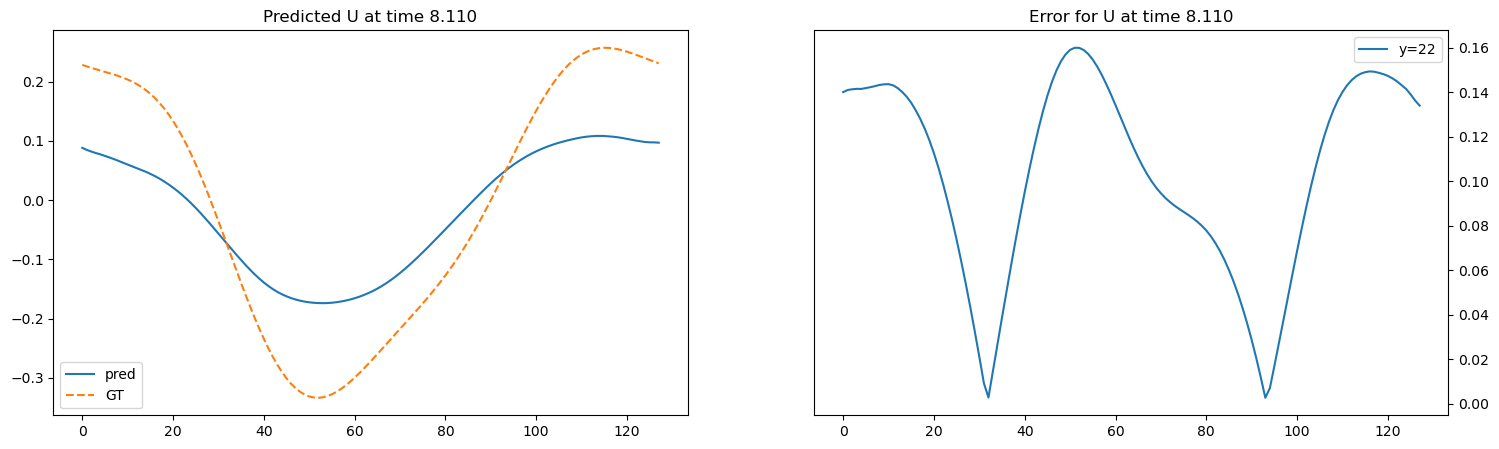

In [23]:
j= 22
for i in range(0, 900, 100):
    plt.figure(figsize=(18, 5))
    time_value = 0.01 * (11 + i)
    time_str = f"{time_value:.3f}" 

    # Left plot: Predicted U
    plt.subplot(1, 2, 1)
   
    plt.plot(pred_sequence_u[i, :, j].detach().cpu().numpy(), label=f'pred')
    plt.plot(gt_u[i, :, j].detach().cpu().numpy(), '--', label=f'GT')
    plt.title(f"Predicted U at time {time_str}")
    plt.legend()
   # plt.colorbar()

    # Fourth plot: Error along center slice
    plt.subplot(1, 2, 2)
   
    plt.plot(np.abs(pred_sequence_u[i, :, j].detach().cpu().numpy() -gt_u[i, :, j].detach().cpu().numpy()), label=f'y={j}')
    plt.legend()
    plt.title(f"Error for U at time {time_str}")
    
    # Set y-ticks on the right
    plt.gca().yaxis.tick_right()
    #plt.savefig(f'./figures/ntime_liftedfunet/liftedfunet_test_result_time={(i + 11)}_NS_multi_traj_data_random_IC_extrapolation_IC={idx}_fixed_x_y={j}.png')
    plt.show()


In [24]:
def compute_radial_energy_spectrum(matrix, num_bins=32):
    """
    Compute the radial energy spectrum for a 2D input matrix.

    Parameters:
    - matrix: 2D numpy array (spatial domain)
    - num_bins: Number of bins for the radial spectrum (each bin with a width of 1)

    Returns:
    - energy_bins: 1D array containing the total energy in each radial bin
    - bin_edges: Array of bin edges used in the histogram
    """
    # Compute the 2D FFT and shift zero frequency to the center
    F = np.fft.fft2(matrix)
    F_shifted = np.fft.fftshift(F)
    
    # Compute the energy (squared magnitude)
    energy = np.abs(F_shifted)**2

    # Get dimensions and compute distance (wave number) from the center
    nrows, ncols = matrix.shape
    center_row, center_col = nrows // 2, ncols // 2
    y, x = np.indices((nrows, ncols))
    r = np.sqrt((x - center_col)**2 + (y - center_row)**2)
    
    # Define bins from 0 to num_bins (each bin width = 1)
    bin_edges = np.arange(0, num_bins + 1, 1)
    
    # Sum the energy in each radial bin
    energy_bins, _ = np.histogram(r, bins=bin_edges, weights=energy)
    
    return energy_bins, bin_edges

In [25]:
def compare_radial_spectra(pred_sequence, gt_sequence, num_bins=32):
    """
    Compute the radial energy spectra for both pred_sequence and gt_sequence.
    
    Parameters:
    - pred_sequence: numpy array of shape (T, dim, dim) for the predicted data
    - gt_sequence: numpy array of shape (T, dim, dim) for the ground truth data
    - num_bins: number of radial bins
    
    Returns:
    - pred_spectra: array of shape (T, num_bins) with radial energies for pred_sequence
    - gt_spectra: array of shape (T, num_bins) with radial energies for gt_sequence
    - bin_edges: the bin edges used in the computation
    """
    T = 900
    print(T)
    pred_spectra = []
    gt_spectra = []
    
    for t in range(T):
        pred_energy, bin_edges = compute_radial_energy_spectrum(pred_sequence[t], num_bins)
        gt_energy, _ = compute_radial_energy_spectrum(gt_sequence[t], num_bins)
        pred_spectra.append(pred_energy)
        gt_spectra.append(gt_energy)
    
    pred_spectra = np.array(pred_spectra)
    gt_spectra = np.array(gt_spectra)
    
    return pred_spectra, gt_spectra, bin_edges

In [26]:
def plot_average_spectra(pred_spectra, gt_spectra, bin_edges):
    """
    Plot the average radial energy spectrum for the predicted and ground truth sequences.
    
    Parameters:
    - pred_spectra: array of shape (T, num_bins)
    - gt_spectra: array of shape (T, num_bins)
    - bin_edges: bin edges array from the spectrum calculation
    """
    # Average spectra over time steps
    pred_avg = np.mean(pred_spectra, axis=0)
    gt_avg = np.mean(gt_spectra, axis=0)
    
    # Compute bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    for i in range(0, len(pred_spectra), 100):
        plt.figure(figsize=(8, 5))
        plt.semilogy(bin_centers, pred_spectra[i], marker='o', label='Predicted')
        plt.semilogy(bin_centers, gt_spectra[i], marker='o', label='Ground Truth')
        plt.xlabel('Wave number')
        plt.ylabel('Energy')
        time_value = 0.1 * (11 + i)
        time_str = f"{time_value:.3f}" 
        plt.title(r'Radial Energy Spectrum time t = ' + time_str)
        plt.legend()
        plt.grid(True)
        #plt.savefig(f'./figures/ntime_liftedfunet/liftedfunet_energy_spectrum_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}.png')
        plt.show()
    plt.figure(figsize=(8, 5))
    plt.semilogy(bin_centers, pred_avg, marker='o', label='Predicted')
    plt.semilogy(bin_centers, gt_avg, marker='o', label='Ground Truth')
    plt.xlabel('Wave number')
    plt.ylabel('Energy')
    plt.title('Average Radial Energy Spectrum')
    plt.legend()
    plt.grid(True)
    #plt.savefig(f'./figures/ntime_liftedfunet/liftedfunet_avg_energy_spectrum_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}.png')
    plt.show()

In [27]:
pred_spectra, gt_spectra, bin_edges = compare_radial_spectra(pred_sequence_u.cpu().detach().numpy(), gt_u.cpu().detach().numpy(), num_bins=32)

900


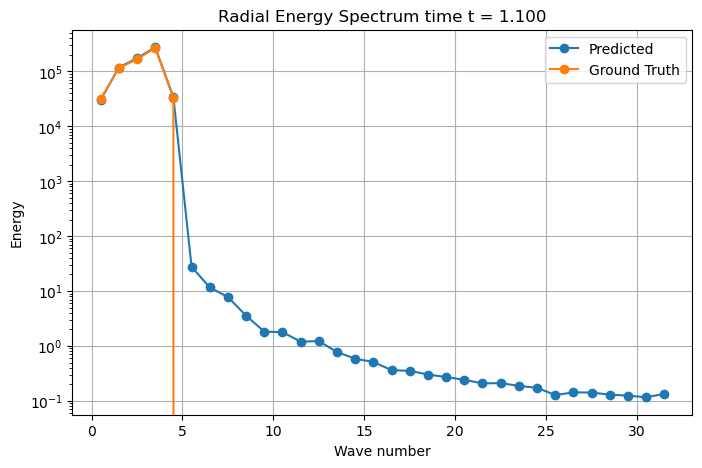

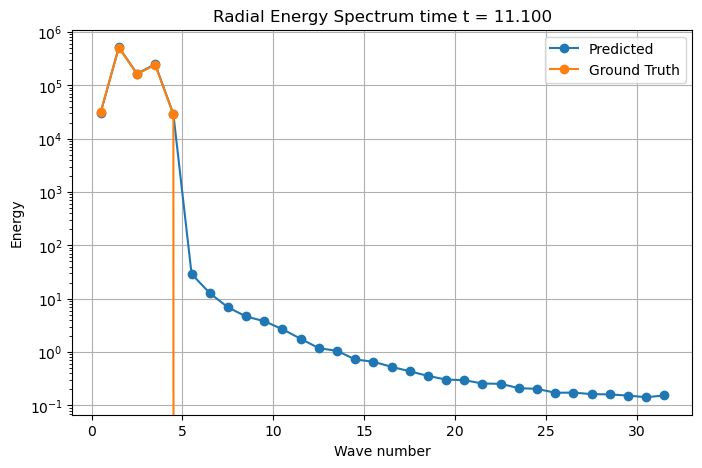

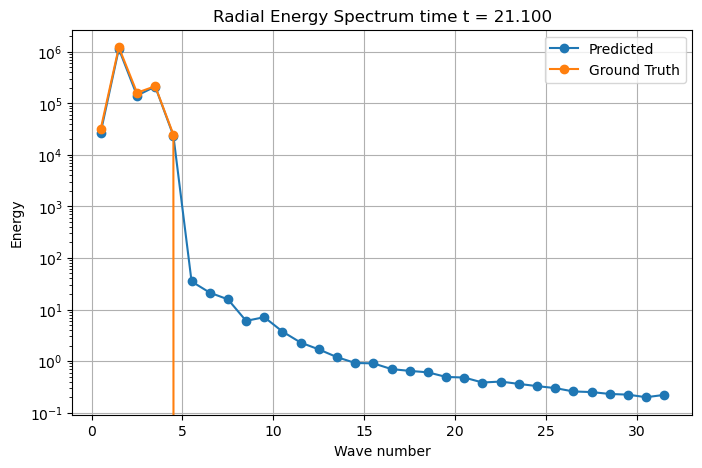

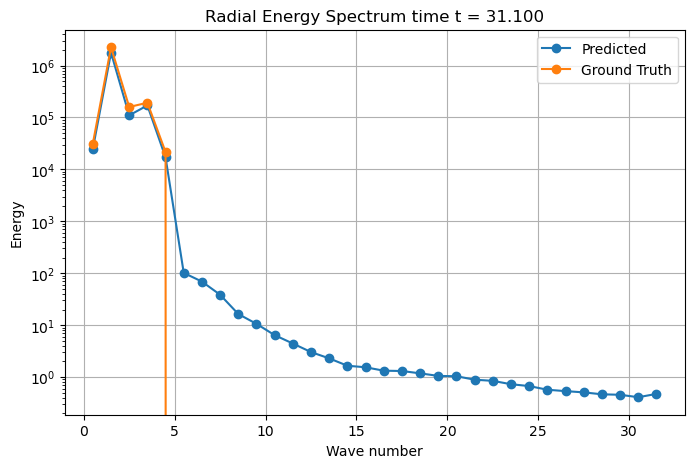

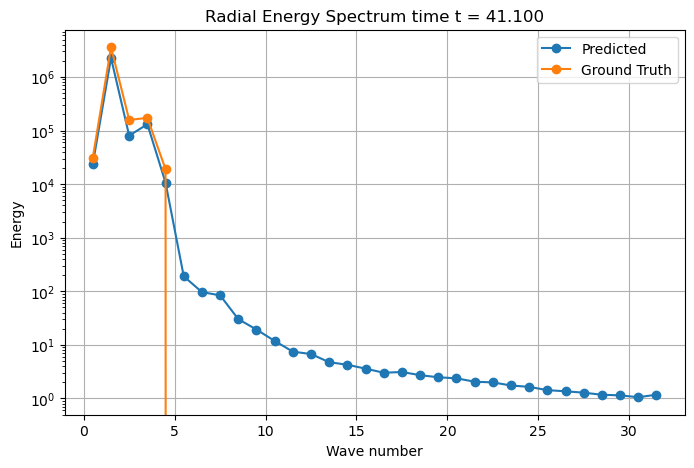

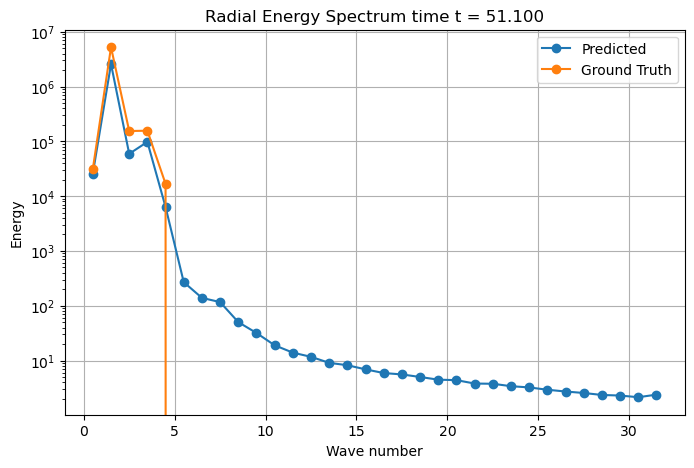

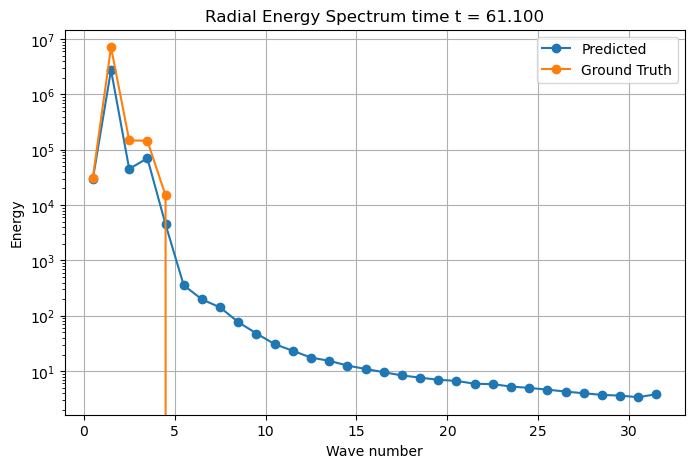

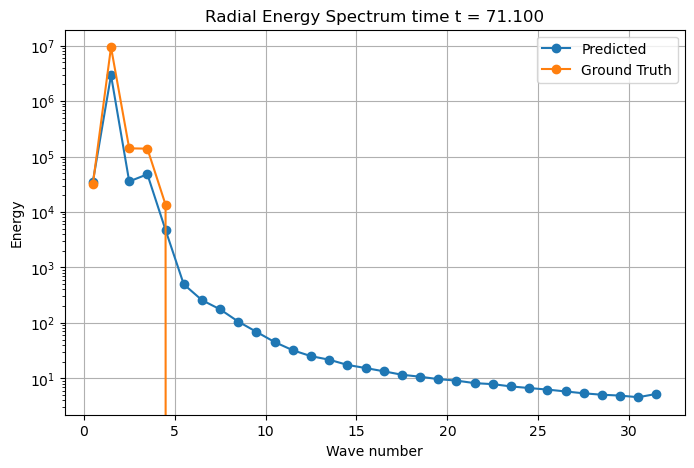

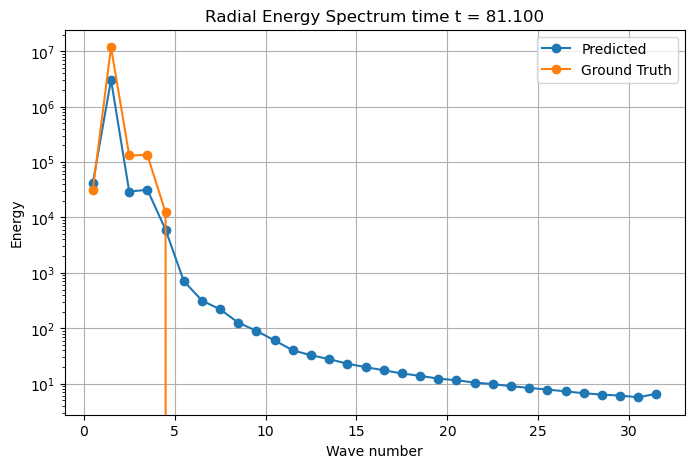

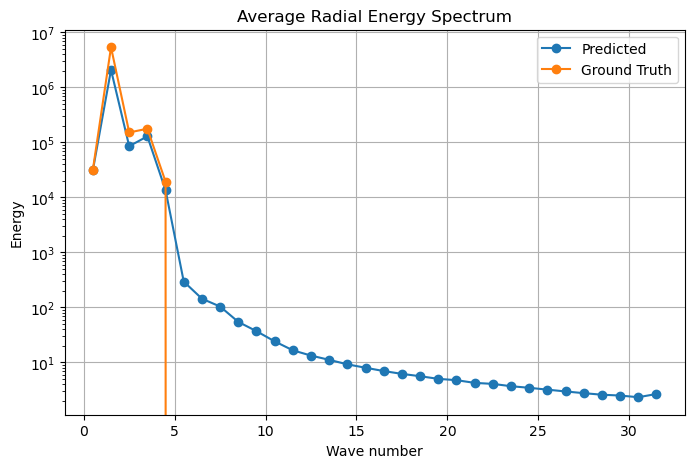

In [28]:
plot_average_spectra(pred_spectra, gt_spectra, bin_edges)